# Das AUVIS-System für die CHiME-9 Multi-Modal Context-aware Recognition (MCoRec) Challenge

## Installation

- Daten herunterladen
- Entwicklungsumgebung erstellen
- ...

## Imports

In [6]:
import os
import re
import json

import pandas as pd
import matplotlib.pyplot as plt

## Subtask 1: Active Speaker Detection

### ASD-Scores berechnen

Die ASD-Scores können über die `asd.py` im Ordner `script` berechnet werden. Standardmäßig wird dazu das Model `finetuning_TalkSet.model` verwendet, die Modell-Datei des Light-ASD-Modells. Um ein anderes Modell für die Berechnung verwenden zu können wurde das zusätzliche Argument `--model` implementiert. Zur Auswahl für dieses Attributs stehen neben der Modell-Datei für das Light-ASD-Modell, die des Light-Robust-ASD-Modells `finetuning_TalkSet_lrasd.model` sowie das auf dem MCoRec weitertrainierte Light-Robust-ASD-Modell `finetuning_MCoRec_5_epoch.model`.

Die Auswahl der zu verarbeiteten Sessions funktioniert über die Angabe des `dataset`. Diese Angabe kann entweder `dev` für den Entwicklungsdatensatz oder `train` für den Trainingsdatensatz sein. 

Zuletzt wird ein Ordner angegeben, in dem die berechneten ASD-Scores gespeichert werden sollen, damit bei der Berechnung mit verschiedenen Modellen die Scores nicht überschrieben, sondern separat gespeichert werden. Hier werden die Scores unter `data-bin/output/<name>` gespeichert. 

Im folgenden wird die Schleife für die Berechnung aller Tracks gezeigt. Aus zeittechnischen Gründen wird an dieser Stelle nur `session_48/spk_1/track_00` verarbeitet.

In [2]:
model_file = "finetuning_MCoRec_5_epoch.model"
dataset = "dev"
dataset_folder = f"data-bin/{dataset}"
output_folder = "mcorec_asd_scores"
    
sessions = os.listdir(dataset_folder) 
print(sessions)

for session in sessions:

    if session != "session_48":
        continue

    print(session)
    session_speakers_path = f"{dataset_folder}/{session}/speakers"
    pattern = re.compile(r'^track_\d{2}\.mp4$')
    
    for speaker in os.listdir(session_speakers_path):
    
        print(speaker)
        speaker_files = os.listdir(f"{session_speakers_path}/{speaker}/central_crops")
        speaker_tracks = [file for file in speaker_files if pattern.match(file)]
    
        for track in speaker_tracks:
    
            print(track)
            video_path = f"{session_speakers_path}/{speaker}/central_crops/{track}"
            output_path = f"data-bin/output/{output_folder}/{dataset}/{session}/speakers/{speaker}"
            !conda run -p conda-env/mcorec python script/asd.py --video {video_path} --output_dir {output_path} --model {model_file}
            break
        break
    break


['session_138', 'session_132', 'session_43', 'session_49', 'session_50', 'session_57', 'session_44', 'session_135', 'session_40', 'session_53', 'session_54', 'session_136', 'session_141', 'session_134', 'session_56', 'session_51', 'session_133', 'session_139', 'session_48', 'session_42', 'session_140', 'session_137', 'session_55', 'session_52', 'session_41']
session_48
spk_1
track_00.mp4
02-17 20:34:09 Model para number = 0.84
MCoRec-ASD-Model loaded successfully.
ASD results saved to: data-bin/output/mcorec_asd_scores/dev/session_48/speakers/spk_1/track_00_asd.json



### ASD-Scores vergleichen

Die zuvor berechneten ASD-Scores aus den verschiedenen Modellen können nun miteinander verglichen werden. 

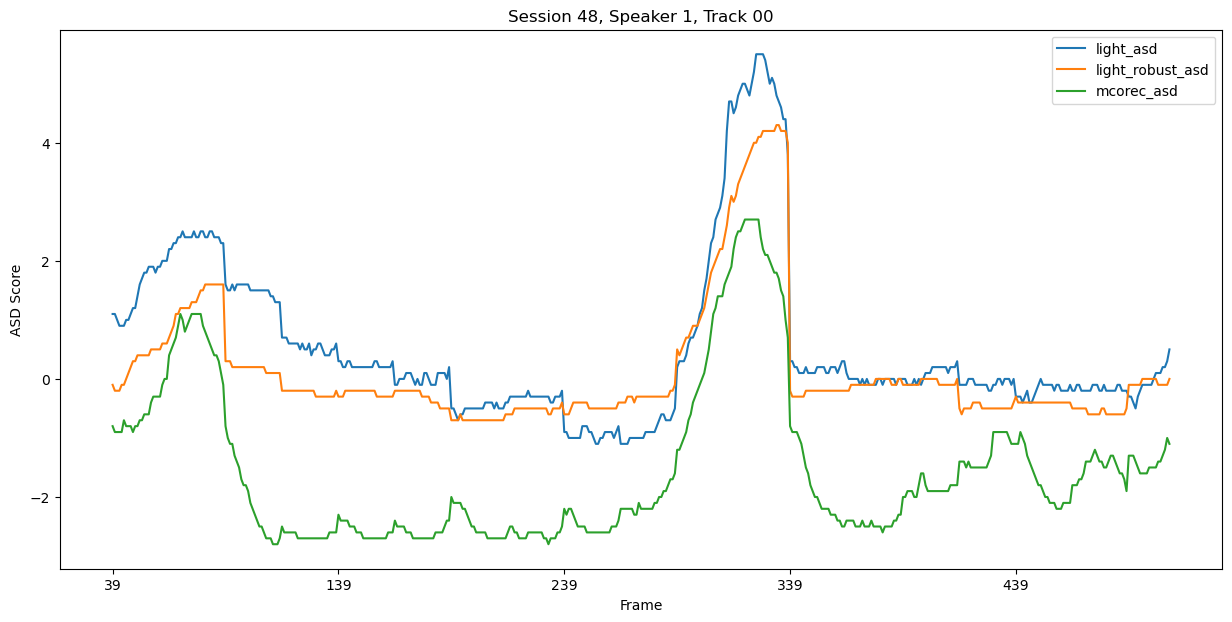

In [8]:
asd_models =  ["light_asd", "light_robust_asd", "mcorec_asd"]

df = None
dataset = "dev"
session = "session_48"
speaker = "spk_1"
track = "track_00"

for i, model in enumerate(asd_models):
    asd_path = f"data-bin/output/{model}_scores/dev/{session}/speakers/{speaker}/{track}_asd.json"

    with open(asd_path, "r") as f:
        asd_scores = json.load(f)

    new_df = pd.DataFrame.from_dict(asd_scores, orient="index", columns=[model])

    if df is None:
        df = new_df
    else:
        df = df.join(new_df)

ax = df.plot(figsize=(15,7), xlabel="Frame", ylabel="ASD Score", title=f"Session {session.split('_')[1]}, Speaker {speaker.split('_')[1]}, Track {track.split('_')[1]}")
# ax.axhline(y=1.0, color="red", linestyle="--", linewidth=1)

plt.show()

## Subtask 2: Face Landmark Detection and Mouth Cropping

## Subtask 3: Video Segmentation and Chunking 

## Subtask 4: Audio-Visual Speech Recognition

## Subtask 5: Time-based Conversation Clustering